In [1]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import json

import sklearn.decomposition
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import metrics

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


## Goldman Sachs API

In [5]:
# # Getting access token

# auth_data = {
#     'grant_type'    : 'client_credentials',
# #     'client_id'     : '',
# #     'client_secret' : '',
#     'scope'         : 'read_product_data read_financial_data read_content'
# }

# # create Session instance
# session = requests.Session()

# # make a POST to retrieve access_token
# auth_request = session.post('https://idfs.gs.com/as/token.oauth2', data = auth_data)
# access_token_dict = json.loads(auth_request.text)
# access_token = access_token_dict['access_token']

# # update session headers
# session.headers.update({'Authorization':'Bearer '+ access_token})

In [6]:
# # Grabbing all gsids

# request_url = 'https://api.marquee.gs.com/v1/data/USCANFPP_MINI/coverage?limit=100'
# request = session.get(url=request_url)
# data = json.loads(request.text)
# df = pd.DataFrame(data['results'])
# gsids = df.gsid

In [7]:
# def getStock(gsid):
#     payload = {
#     "startDate": "2013-03-04",
# #     "endDate": "2016-07-13",
#         "endDate": "2018-07-13",
#     "where": {
#         "gsid": [gsid]
#         }
#     }
#     request_url = 'https://api.marquee.gs.com/v1/data/USCANFPP_MINI/query'
#     request = session.post(url=request_url, json = payload)
#     results = json.loads(request.text)
#     data = results['data']
# #     print(data)
#     return pd.DataFrame.from_dict(data)

In [8]:
with open('GSData.pickle','rb') as handle:
    GSData=pickle.load(handle)

In [9]:
GSData.keys()
gsids,gsidDict,allStockData,IDNameTable=GSData['gsids'], GSData['gsidDict'], GSData['allStockData'], GSData['IDNameTable']

In [10]:
def findStock(gsid, allStockData):
    for i in range(len(allStockData)):
        if allStockData[i]['gsid'][0]==gsid:
            return i

In [11]:
findStock('26403', allStockData)

76

In [12]:
# Grab all stocks
stockData=[];
for i in range(0,99):
    if i!=76:
        stockData.append(allStockData[i])

In [13]:
def subtractDates(date1, earliestDate):
    return (datetime.strptime(date1, '%Y-%m-%d')-datetime.strptime(earliestDate, '%Y-%m-%d')).days

In [14]:
# Get output 

Disney_df=allStockData[76]
Disney_df.set_index('date',drop=True,inplace=True);
Disney_df.drop(labels='updateTime', axis=1,inplace=True)
Disney_df.drop(labels='gsid', axis=1,inplace=True)

for index, row in Disney_df.iterrows():
    Disney_df.loc[index,'SubtractDates']=subtractDates(index,'2015-01-01')

In [15]:
# Only select dates after 2015-1-1

Disney_df=Disney_df[Disney_df['SubtractDates']>=0].copy(True)

In [16]:
# Check if any null values
Disney_df.isnull().any().any()

False

In [17]:
# Grab the scores for Disney
yOutput=Disney_df.iloc[:,0:4]

In [18]:
yOutput=yOutput.as_matrix()

In [19]:
yOutput.shape

(652, 4)

In [20]:
np.mean(yOutput)

0.5594723926380368

In [21]:
for i in range(0,98):
    stockData[i].set_index('date',drop=True,inplace=True)

In [22]:
for i in range(0,98):
    stockData[i].drop(labels='updateTime', axis=1,inplace=True)
    stockData[i].drop(labels='gsid', axis=1,inplace=True)

# Starting all Data manipulation

In [23]:
allFrame=stockData[0];
for jj in range(1,98):
    allFrame=pd.concat([allFrame,stockData[jj]], axis=1)

In [24]:
for index,row in allFrame.iterrows():
#     print(index)
    allFrame.loc[index,'SubtractDates']=subtractDates(index,'2015-01-01')

In [25]:
# Only select dates after 2015-1-1

allFrame=allFrame[allFrame['SubtractDates']>=0].copy(True)

In [26]:
allFrame.set_index('SubtractDates',drop=False,inplace=True)

In [27]:
allFrame.shape

(652, 393)

In [28]:
# Do interpolation

In [29]:
# Order probably not ideal
allFrame.interpolate(method='spline', order=5, inplace=True)

# Import sentiment analysis

In [30]:
with open('Disney-time-tone.pkl','rb') as handle:
    array_SA=pickle.load(handle)

# Scale: 100 very good, -100 very bad

In [31]:
array_SA.shape

(2, 365)

In [32]:
SA_data={'SubtractDates': array_SA.transpose()[:,0], 'Sentiment': array_SA.transpose()[:,1]}
df_SA=pd.DataFrame(SA_data).set_index('SubtractDates',drop=True)

In [33]:
allData=pd.concat([allFrame,df_SA],axis=1)

In [34]:
filtered_Data=allData.dropna().copy()

In [35]:
len(filtered_Data)

261

In [36]:
# allFrame.drop('SubtractDates',axis=1,inplace=True)
filtered_Data.drop('SubtractDates',axis=1,inplace=True)
allFrame=filtered_Data.copy()

In [37]:
yOutput=Disney_df.iloc[:,0:4]
yOutput=yOutput.as_matrix()
yOutput.shape
yOutput=yOutput[0:261,:]

In [38]:
yOutput.shape

(261, 4)

# Start PCA

In [39]:
pca = sklearn.decomposition.PCA(n_components=10)

In [40]:
pca.fit(allFrame)
# pca.fit(filtered_Data)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [41]:
print(np.argmax(pca.components_))

392


In [42]:
print(pca.explained_variance_ratio_)

[0.51429657 0.20320079 0.09599645 0.03807935 0.03068876 0.0266889
 0.02105636 0.01121713 0.00935362 0.00806343]


In [43]:
print(np.sum(pca.explained_variance_ratio_))

0.9586413579456229


In [44]:
inputData=pca.transform(allFrame)
inputData.shape

(261, 10)

In [45]:
# # Not needed anymore

inputData=inputData[:-2,:]
inputData.shape

(259, 10)

In [46]:
yOutput=Disney_df.iloc[:,0:4]
yOutput=yOutput.as_matrix()
yOutput.shape
yOutput=yOutput[1:260,:]
yOutput.shape

(259, 4)

# Feed into neural network

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputData, yOutput, test_size=0.2, random_state=42)

In [48]:
# testList=[];
# for i in range(1,7):
#     for j in range(1,7):

#         model0 = Sequential()
#         model0.add(Dense(10, input_shape=(10,), use_bias=True, kernel_initializer='random_uniform', activation='tanh', kernel_regularizer=regularizers.l2(0.2*j),activity_regularizer=regularizers.l1(1)))
#         model0.add(Dropout(0.1*i))
#         model0.add(Dense(4, use_bias=True, kernel_initializer='random_uniform', activation='tanh'))
#         model0.output_shape
#         model0.compile(loss='mean_absolute_error',
#                       optimizer='adam')

#         hist=model0.fit(inputData, yOutput, epochs=200, batch_size=16, validation_split=0.1, shuffle=True)
#         testList.append(hist.history['val_loss'][-1])

In [49]:
i=3;
j=6;

model0 = Sequential()
model0.add(Dense(10, input_shape=(10,), use_bias=True, kernel_initializer='random_uniform', activation='tanh', kernel_regularizer=regularizers.l2(0.2*j),activity_regularizer=regularizers.l1(1)))
model0.add(Dropout(0.1*i))
model0.add(Dense(4, use_bias=True, kernel_initializer='random_uniform', activation='tanh'))
model0.output_shape
model0.compile(loss='mean_absolute_error',
              optimizer='adam')
hist=model0.fit(X_train, y_train, epochs=300, batch_size=16, validation_split=0.5, shuffle=True)

Train on 103 samples, validate on 104 samples
Epoch 1/300
103/103 [==============================] - 0s 364us/step - loss: 6.7684 - val_loss: 5.9974
Epoch 2/300
103/103 [==============================] - 0s 88us/step - loss: 5.3573 - val_loss: 4.7903
Epoch 3/300
103/103 [==============================] - 0s 97us/step - loss: 4.2137 - val_loss: 3.7521
Epoch 4/300
103/103 [==============================] - 0s 127us/step - loss: 3.2019 - val_loss: 2.9079
Epoch 5/300
103/103 [==============================] - 0s 166us/step - loss: 2.4654 - val_loss: 2.2590
Epoch 6/300
103/103 [==============================] - 0s 136us/step - loss: 1.8081 - val_loss: 1.6708
Epoch 7/300
103/103 [==============================] - 0s 94us/step - loss: 1.3678 - val_loss: 1.3150
Epoch 8/300
103/103 [==============================] - 0s 107us/step - loss: 1.1187 - val_loss: 1.0430
Epoch 9/300
103/103 [==============================] - 0s 106us/step - loss: 0.9042 - val_loss: 0.8251
Epoch 10/300
103/103 [========

103/103 [==============================] - 0s 146us/step - loss: 0.2130 - val_loss: 0.2057
Epoch 80/300
103/103 [==============================] - 0s 107us/step - loss: 0.2045 - val_loss: 0.2075
Epoch 81/300
103/103 [==============================] - ETA: 0s - loss: 0.208 - 0s 171us/step - loss: 0.2030 - val_loss: 0.1940
Epoch 82/300
103/103 [==============================] - 0s 140us/step - loss: 0.1949 - val_loss: 0.2120
Epoch 83/300
103/103 [==============================] - 0s 94us/step - loss: 0.1932 - val_loss: 0.1865
Epoch 84/300
103/103 [==============================] - 0s 204us/step - loss: 0.1803 - val_loss: 0.2051
Epoch 85/300
103/103 [==============================] - 0s 123us/step - loss: 0.1996 - val_loss: 0.2065
Epoch 86/300
103/103 [==============================] - 0s 175us/step - loss: 0.1969 - val_loss: 0.2069
Epoch 87/300
103/103 [==============================] - 0s 458us/step - loss: 0.1966 - val_loss: 0.1948
Epoch 88/300
103/103 [==============================] 

103/103 [==============================] - 0s 87us/step - loss: 0.1224 - val_loss: 0.1186
Epoch 158/300
103/103 [==============================] - 0s 107us/step - loss: 0.1068 - val_loss: 0.1092
Epoch 159/300
103/103 [==============================] - 0s 88us/step - loss: 0.0998 - val_loss: 0.1240
Epoch 160/300
103/103 [==============================] - 0s 96us/step - loss: 0.1105 - val_loss: 0.1079
Epoch 161/300
103/103 [==============================] - 0s 78us/step - loss: 0.1023 - val_loss: 0.1236
Epoch 162/300
103/103 [==============================] - 0s 107us/step - loss: 0.1127 - val_loss: 0.1179
Epoch 163/300
103/103 [==============================] - 0s 78us/step - loss: 0.1043 - val_loss: 0.1161
Epoch 164/300
103/103 [==============================] - 0s 107us/step - loss: 0.1110 - val_loss: 0.1213
Epoch 165/300
103/103 [==============================] - 0s 88us/step - loss: 0.1103 - val_loss: 0.1175
Epoch 166/300
103/103 [==============================] - 0s 88us/step - los

103/103 [==============================] - 0s 119us/step - loss: 0.1098 - val_loss: 0.1140
Epoch 236/300
103/103 [==============================] - 0s 97us/step - loss: 0.1041 - val_loss: 0.1183
Epoch 237/300
103/103 [==============================] - 0s 97us/step - loss: 0.1058 - val_loss: 0.1236
Epoch 238/300
103/103 [==============================] - 0s 107us/step - loss: 0.1169 - val_loss: 0.1261
Epoch 239/300
103/103 [==============================] - 0s 136us/step - loss: 0.1175 - val_loss: 0.1308
Epoch 240/300
103/103 [==============================] - 0s 97us/step - loss: 0.1139 - val_loss: 0.1202
Epoch 241/300
103/103 [==============================] - 0s 97us/step - loss: 0.1127 - val_loss: 0.1295
Epoch 242/300
103/103 [==============================] - 0s 96us/step - loss: 0.1107 - val_loss: 0.1235
Epoch 243/300
103/103 [==============================] - 0s 106us/step - loss: 0.1119 - val_loss: 0.1227
Epoch 244/300
103/103 [==============================] - 0s 110us/step - l

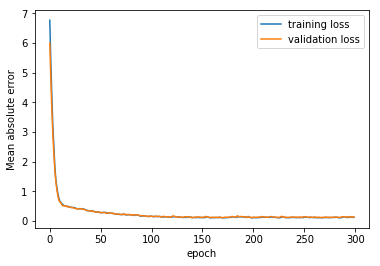

In [50]:
vector=np.arange(300)
plt.plot(vector,hist.history['loss'],label='training loss')
plt.plot(vector,hist.history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('Mean absolute error')
plt.legend()
# plt.savefig('Training and Validation Error')
plt.show()

In [51]:
# Calculate the mean absolute percentage error, on the test data set

np.mean(abs(y_test-model0.predict(X_test))/y_test)*100

9.047916452161955

In [52]:
model0.predict(X_test).shape

(52, 4)

In [53]:
hist.history['val_loss'][-1]

0.12397211446211888

In [54]:
# Weights and biases
for i in range(4):
    print(np.asanyarray(model0.get_weights()[i]).squeeze().shape)

(10, 10)
(10,)
(10, 4)
(4,)


# Trying IEX Trading

In [58]:
# IEX can give us 

def getStockPrice5yr(StockAbbrev):
    url='https://api.iextrading.com/1.0'
    response=requests.get(url+'/stock/'+StockAbbrev + '/chart/5y')
    data_df=pd.DataFrame.from_dict(response.json())
    return data_df

In [59]:
DIS_df=getStockPrice5yr('DIS')

In [60]:
DIS_df.set_index('date',drop=True,inplace=True)

In [61]:
for index, row in DIS_df.iterrows():
    print(index)
    DIS_df.loc[index,'SubtractDates']=subtractDates(index,'2015-01-01')

2013-03-06
2013-03-07
2013-03-08
2013-03-11
2013-03-12
2013-03-13
2013-03-14
2013-03-15
2013-03-18
2013-03-19
2013-03-20
2013-03-21
2013-03-22
2013-03-25
2013-03-26
2013-03-27
2013-03-28
2013-04-01
2013-04-02
2013-04-03
2013-04-04
2013-04-05
2013-04-08
2013-04-09
2013-04-10
2013-04-11
2013-04-12
2013-04-15
2013-04-16
2013-04-17
2013-04-18
2013-04-19
2013-04-22
2013-04-23
2013-04-24
2013-04-25
2013-04-26
2013-04-29
2013-04-30
2013-05-01
2013-05-02
2013-05-03
2013-05-06
2013-05-07
2013-05-08
2013-05-09
2013-05-10
2013-05-13
2013-05-14
2013-05-15
2013-05-16
2013-05-17
2013-05-20
2013-05-21
2013-05-22
2013-05-23
2013-05-24
2013-05-28
2013-05-29
2013-05-30
2013-05-31
2013-06-03
2013-06-04
2013-06-05
2013-06-06
2013-06-07
2013-06-10
2013-06-11
2013-06-12
2013-06-13
2013-06-14
2013-06-17
2013-06-18
2013-06-19
2013-06-20
2013-06-21
2013-06-24
2013-06-25
2013-06-26
2013-06-27
2013-06-28
2013-07-01
2013-07-02
2013-07-03
2013-07-05
2013-07-08
2013-07-09
2013-07-10
2013-07-11
2013-07-12
2013-07-15